In [1]:
import os

import keras

from classification_models.keras import Classifiers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras.metrics import top_k_categorical_accuracy
from keras.optimizers import SGD

Using TensorFlow backend.


### Configurações de treino

In [2]:
def tl_scheduler(epoch):
    if epoch < 6:
        return 0.005
    elif epoch < 11:
        return 0.001
    elif epoch < 21:
        return 0.005
    elif epoch < 28:
        return 0.001
    elif epoch < 36:
        return 0.0005
    else:
        return 0.0001


In [3]:
training_config = {
    'batch_size': 128,
    'target_size': (224,224),
    'epochs': 55,
    'lr': 0.005,
    'decay': 0,
    'seed': 42
}

### Carregando Dataset

In [4]:
experiments_path = '/data/alberto/iWildCam2020/experiments'
experiment = 'resnet18_iwild205_21042020'

In [5]:
train_dir = '/data/alberto/iWildCam2020/resized/train_resized'
validation_dir = '/data/alberto/iWildCam2020/resized/validation_resized'

In [6]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=training_config['target_size'],
        batch_size=training_config['batch_size'],
        class_mode='categorical',
        shuffle=True,
        seed=training_config['seed'])

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=training_config['target_size'],
        batch_size=training_config['batch_size'],
        class_mode='categorical',
        classes=sorted(list(train_generator.class_indices.keys())))

Found 203689 images belonging to 3 classes.
Found 56736 images belonging to 3 classes.


### Calbacks

In [7]:
model_path = os.path.join(experiments_path, experiment, 'models', 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5')
if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))

checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy'
)

checkpoint_best = ModelCheckpoint(
    filepath=os.path.join(experiments_path, experiment, 'models', 'best.hdf5'),
    save_best_only=True,
    monitor='val_accuracy'
)

csv_path = os.path.join(experiments_path, experiment, 'history', 'training.log')
if not os.path.exists(os.path.dirname(csv_path)):
    os.makedirs(os.path.dirname(csv_path))

csv_logger = CSVLogger(csv_path, append=True)

lr_scheduler = LearningRateScheduler(tl_scheduler)

In [8]:
callbacks = [checkpoint, checkpoint_best, csv_logger, lr_scheduler]

### Definindo Métricas

In [9]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

### Preparando modelo 

In [10]:
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [11]:
base_model = ResNet18(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(validation_generator.class_indices), activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])

In [12]:
for layer in model.layers:
    layer.trainable = True

In [13]:
optimizer = SGD(lr=training_config['lr'], momentum=0.9, decay=0)

In [14]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

In [15]:
current_epoch = 0

### Treinando modelo

In [16]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n // training_config['batch_size'],
            epochs=training_config['epochs'],
            validation_data=validation_generator,
            validation_steps=validation_generator.n // training_config['batch_size'],
            callbacks=callbacks,
            initial_epoch=current_epoch,
            use_multiprocessing=True,
            workers=8)

Epoch 1/55
1591/1591 [==============================] - 1180s 742ms/step - loss: 0.1069 - accuracy: 0.9642 - top_5_accuracy: 1.0000 - val_loss: 0.0799 - val_accuracy: 0.9589 - val_top_5_accuracy: 1.0000
Epoch 2/55
1591/1591 [==============================] - 838s 527ms/step - loss: 0.0754 - accuracy: 0.9740 - top_5_accuracy: 1.0000 - val_loss: 0.1423 - val_accuracy: 0.9561 - val_top_5_accuracy: 1.0000
Epoch 3/55
1591/1591 [==============================] - 838s 527ms/step - loss: 0.0645 - accuracy: 0.9767 - top_5_accuracy: 1.0000 - val_loss: 0.1423 - val_accuracy: 0.9726 - val_top_5_accuracy: 1.0000
Epoch 4/55
1591/1591 [==============================] - 838s 527ms/step - loss: 0.0560 - accuracy: 0.9794 - top_5_accuracy: 1.0000 - val_loss: 0.1298 - val_accuracy: 0.9683 - val_top_5_accuracy: 1.0000
Epoch 5/55
1591/1591 [==============================] - 838s 527ms/step - loss: 0.0493 - accuracy: 0.9813 - top_5_accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.9725 - val_top_5_accura

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1591/1591 [==============================] - 839s 528ms/step - loss: 0.0164 - accuracy: 0.9935 - top_5_accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 0.9850 - val_top_5_accuracy: 1.0000
Epoch 51/55
1591/1591 [==============================] - 839s 527ms/step - loss: 0.0162 - accuracy: 0.9937 - top_5_accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.9857 - val_top_5_accuracy: 1.0000
Epoch 52/55
 218/1591 [===>..........................] - ETA: 11:02 - loss: 0.0159 - accuracy: 0.9938 - top_5_accuracy: 1.0000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1591/1591 [==============================] - 838s 527ms/step - loss: 0.0163 - accuracy: 0.9935 - top_5_accuracy: 1.0000 - val_loss: 0.0461 - val_accuracy: 0.9851 - val_top_5_accuracy: 1.0000
Epoch 54/55
1591/1591 [==============================] - 840s 528ms/step - loss: 0.0163 - accuracy: 0.9934 - top_5_accuracy: 1.0000 - val_loss: 0.1619 - val_accuracy: 0.9858 - val_top_5_accuracy: 1.0000
Epoch 55/55
1591/1591 [==============================] - 840s 528ms/step - loss: 0.0161 - accuracy: 0.9936 - top_5_accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 0.9853 - val_top_5_accuracy: 1.0000


### Analisando dados pós-treinamento

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

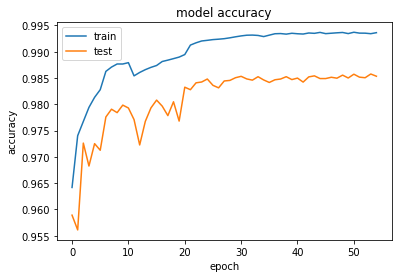

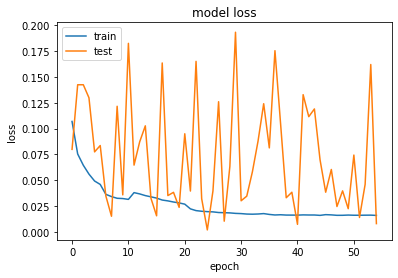

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Gerando matriz de confusão

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator, validation_generator.n // training_config['batch_size']+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 2352  8934]
 [ 9458 35992]]


In [22]:
print('Classification Report')
target_names = ['empty', 'noempty']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       empty       0.20      0.21      0.20     11286
     noempty       0.80      0.79      0.80     45450

    accuracy                           0.68     56736
   macro avg       0.50      0.50      0.50     56736
weighted avg       0.68      0.68      0.68     56736



In [23]:
cm=confusion_matrix(validation_generator.classes, y_pred)

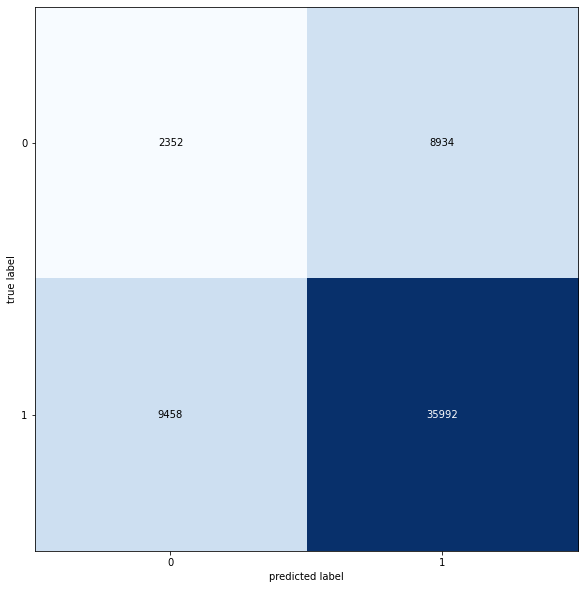

In [24]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(10, 10))
plt.show()

#### Classificação Empty e NoEmpty 67,58% de Acurácia.

Também estamos obtendo 20,83% de sensibilidade e 79,19% de especificidade, o que implica que:

Sensibilidade: indica que  a capacidade indentificar o que é background (empty) com o modelo é de 20,83%.

Especificidade: indica que capacidade indentificar os animais(NoEmpty) com o modelo é de 79,19%.

Dessa forma podemos supor: 

1- A rede acabou se adaptando demais ao modelo, ocasionando um overfiting

2- Houve uma grande dificuldade da rede em identificar o empty. Dessa forma, implica-se supor:

    2.1 - O modelo acabou por deduzir que devido o empty aparecer em todos os casos com animais, ele se adaptou             de tal modo que na menor alteração do bakground, o modelo ja classificava como NoEmpty. 